In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np 
pd.set_option('float_format', '{:f}'.format)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 

plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

import dataload

import requests
import datetime as datetime
from tqdm import tqdm, tqdm_notebook

from tslearn.clustering import TimeSeriesKMeans

In [3]:
buy_full = dataload.load_buy()
print(buy_full.shape)
buy_full.head()

(2056899, 6)


,date,sex,age,big_cat,sm_cat,qty
0,20180101,F,20,식품,가공란,37
1,20180101,F,30,식품,가공란,16
2,20180101,F,40,식품,가공란,9
3,20180101,F,50,식품,가공란,3
4,20180101,M,20,식품,가공란,13


In [85]:
tqdm.pandas()

buy_full['year'] = buy_full['date'].progress_apply(lambda x :str(x)[:4])
buy_2018 = buy_full[buy_full.year=='2018'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2019 = buy_full[buy_full.year=='2019'][['date', 'sex', 'age', 'big_cat', 'sm_cat', 'qty']]
buy_2018['date'] = buy_2018['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))
buy_2019['date'] = buy_2019['date'].progress_apply(lambda x : pd.to_datetime(str(x), format='%Y%m%d'))

buy_2018.shape, buy_2019.shape

100%|██████████| 1051412/1051412 [01:48<00:00, 9699.28it/s] 


((1005487, 6), (1051412, 6))

In [86]:
buy_2018.head()

,date,sex,age,big_cat,sm_cat,qty
0,2018-01-01,F,20,식품,가공란,37
1,2018-01-01,F,30,식품,가공란,16
2,2018-01-01,F,40,식품,가공란,9
3,2018-01-01,F,50,식품,가공란,3
4,2018-01-01,M,20,식품,가공란,13


In [87]:
buy_2018 = buy_2018.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[["date", "big_cat", "sm_cat", "qty"]]
buy_2019 = buy_2019.groupby(['date', 'big_cat', 'sm_cat']).sum('qty').reset_index()[["date", "big_cat", "sm_cat", "qty"]]

In [88]:
buy_2018["date"] = buy_2018["date"] + datetime.timedelta(days=-1)
buy_2018["date"] = buy_2018["date"].progress_apply(lambda x : x.replace(year=2018, month=12, day=31) if x==datetime.date(2017, 12, 31) else x)

100%|██████████| 133489/133489 [00:00<00:00, 271825.79it/s]


In [91]:
buy_2018.date.nunique()

365

In [92]:
buy_2018["date"] = buy_2018["date"].apply(lambda x : str(x)[5:])
buy_2019["date"] = buy_2019["date"].apply(lambda x : str(x)[5:])

In [94]:
# 2018
df_appliance2018 = buy_2018[buy_2018.big_cat == '냉난방가전'].reset_index(drop=True).drop('big_cat', axis=1)
df_beauty2018 = buy_2018[buy_2018.big_cat == '뷰티'].reset_index(drop=True).drop('big_cat', axis=1)
df_food2018 = buy_2018[buy_2018.big_cat == '식품'].reset_index(drop=True).drop('big_cat', axis=1)

df_appliance2018.shape, df_beauty2018.shape, df_food2018.shape

((11598, 3), (45661, 3), (76230, 3))

In [95]:
# 2019
df_appliance2019 = buy_2019[buy_2019.big_cat == '냉난방가전'].reset_index(drop=True).drop('big_cat', axis=1)
df_beauty2019 = buy_2019[buy_2019.big_cat == '뷰티'].reset_index(drop=True).drop('big_cat', axis=1)
df_food2019 = buy_2019[buy_2019.big_cat == '식품'].reset_index(drop=True).drop('big_cat', axis=1)

df_appliance2019.shape, df_beauty2019.shape, df_food2019.shape

((11834, 3), (45901, 3), (76483, 3))

In [96]:
# 가전 
df_appliance2018_ts = pd.pivot_table(df_appliance2018, index="sm_cat", columns="date", values="qty")
df_appliance2019_ts = pd.pivot_table(df_appliance2019, index="sm_cat", columns="date", values="qty")

df_appliance2018_ts.shape, df_appliance2019_ts.shape

((40, 365), (40, 365))

In [97]:
df_appliance2018_ts = df_appliance2018_ts.fillna(0)
df_appliance2019_ts = df_appliance2019_ts.fillna(0)

app_ts = (df_appliance2018_ts + df_appliance2019_ts)/2
app_ts.shape

(40, 365)

In [98]:
app_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

In [99]:
# 뷰티 
df_beauty2018_ts = pd.pivot_table(df_beauty2018, index="sm_cat", columns="date", values="qty")
df_beauty2019_ts = pd.pivot_table(df_beauty2019, index="sm_cat", columns="date", values="qty")

df_beauty2018_ts.shape, df_beauty2019_ts.shape

((131, 365), (131, 365))

In [100]:
df_beauty2018_ts = df_beauty2018_ts.fillna(0)
df_beauty2019_ts = df_beauty2019_ts.fillna(0)

beauty_ts = (df_beauty2018_ts + df_beauty2019_ts)/2
beauty_ts.shape

(131, 365)

In [101]:
beauty_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

# 가전

## 1. 데이터 정규화 

In [102]:
avg_lst = []; std_lst = []
for idx, row in tqdm(app_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())
    
app_ts['avg'] = avg_lst
app_ts['std'] = std_lst


for i in tqdm(range(len(app_ts))):
    for j in range(365):
        app_ts.iloc[i,j] = (app_ts.iloc[i,j] - app_ts.iloc[i,365])/app_ts.iloc[i,366] 

app_ts = app_ts.drop(['avg','std'], axis=1)

40it [00:00, 5249.93it/s]
100%|██████████| 40/40 [00:02<00:00, 18.47it/s]


In [103]:
app_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 2. 최적 k 찾기 

In [41]:
def visualize_elbowmethod(data, param_init='random', param_n_init=10, param_max_iter=300):
    distortions = []
    for i in tqdm(range(2, 7)): 
        ts_clustering = TimeSeriesKMeans(n_clusters=i, max_iter=param_max_iter, random_state=1234, metric = 'dtw')
        ts_clustering.fit(data)
        distortions.append(ts_clustering.inertia_)

    plt.plot(range(2, 7), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

100%|██████████| 5/5 [00:42<00:00,  8.45s/it]


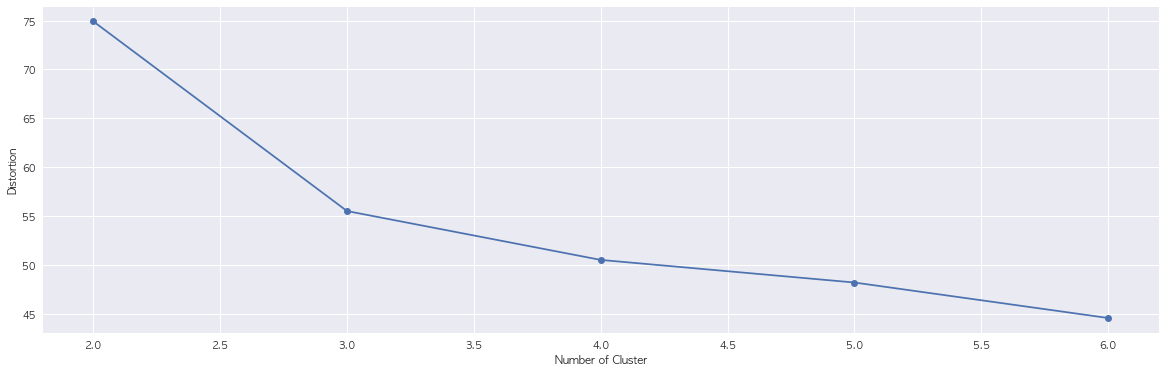

CPU times: user 1min 46s, sys: 7.54 s, total: 1min 54s
Wall time: 42.4 s


In [104]:
%time  visualize_elbowmethod(app_ts)

## 3. TimeSeries K Means

In [105]:
model1 = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(app_ts))) : 
    model1.fit(app_ts)

100%|██████████| 40/40 [04:18<00:00,  6.47s/it]


In [106]:
df_app_result = pd.DataFrame({
    'sm_cat' : app_ts.index, 
    'cluster' : model1.labels_
})

In [107]:
df_app_result.cluster.value_counts()

1    16
0    15
2     9
Name: cluster, dtype: int64

In [108]:
# cluster 0 : 겨울 
df_app_result[df_app_result.cluster==0]

,sm_cat,cluster
1,가열식 가습기,0
4,난방용 열풍기,0
6,돈풍기,0
7,라디에이터,0
13,복합식 가습기,0
19,에어워셔,0
23,온열매트,0
24,온풍기,0
27,자연식 가습기,0
28,전기온수기,0


In [109]:
# cluster 1 : 여름 
df_app_result[df_app_result.cluster==1]

,sm_cat,cluster
2,공기정화 용품,1
3,공기청정기,1
5,냉풍기,1
8,멀티형 에어컨,1
9,벽걸이 에어컨,1
11,벽걸이형 선풍기,1
15,스탠드형 냉온풍기,1
16,스탠드형 에어컨,1
18,업소용 선풍기,1
21,에어컨 리모컨,1


In [110]:
# cluster 2 : 결측치 많은 제품군 
df_app_result[df_app_result.cluster==2]

,sm_cat,cluster
0,가스온수기,2
10,벽걸이형 냉온풍기,2
12,보일러,2
14,산림욕기,2
17,신발건조기,2
20,에어커튼,2
25,의류건조기,2
31,중대형 에어컨,2
32,천장형 에어컨,2


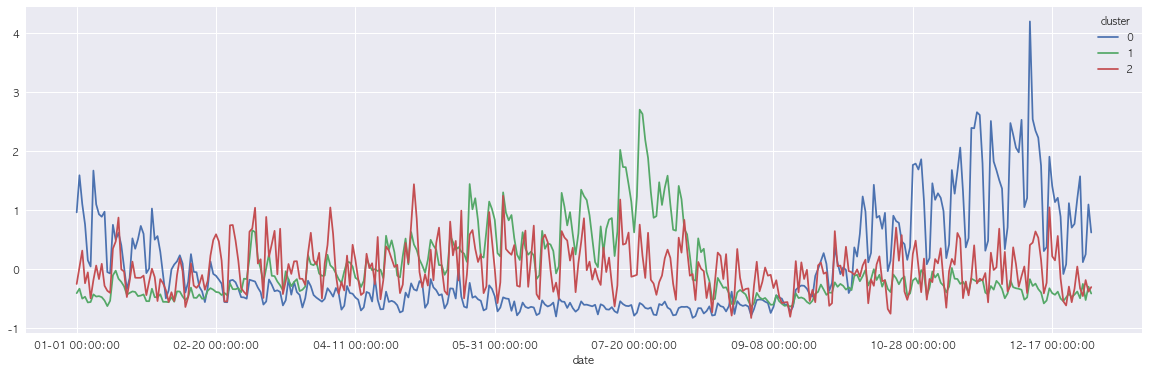

In [112]:
app_ts["cluster"] = model1.labels_

plt.rcParams["figure.figsize"]=(20,6)
app_ts.groupby(['cluster']).mean().T.plot()
plt.show()

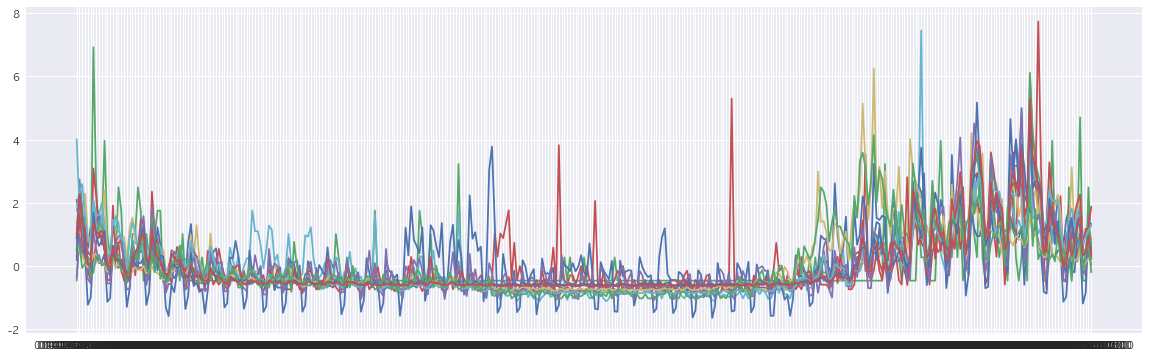

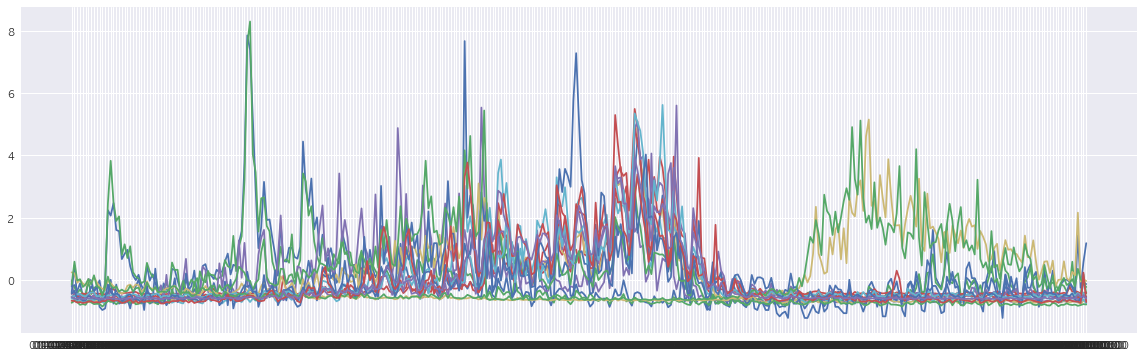

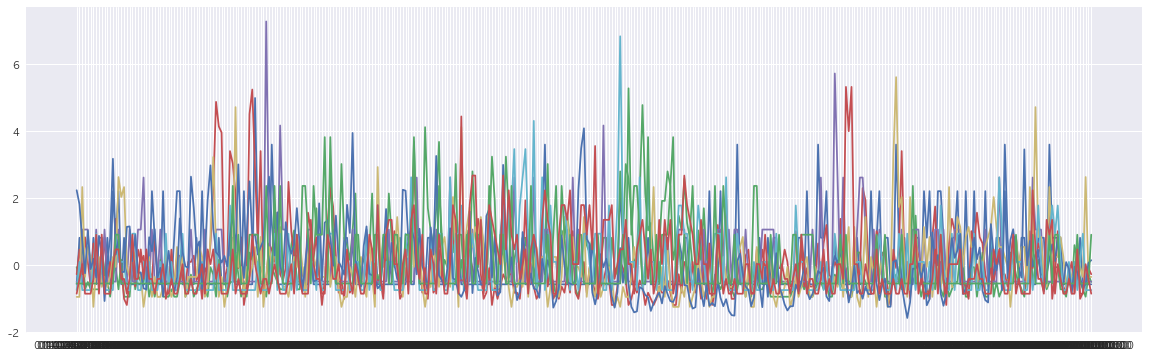

In [113]:
for i in range(3):
    clusters = app_ts[app_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [114]:
app_ts["cluster"] = model1.labels_
app_ts.to_csv("appliance_tsclustering.csv", index=False, encoding='cp949')

# 뷰티 

## 1. 데이터 정규화 

In [115]:
avg_lst = []; std_lst = []
for idx, row in tqdm(beauty_ts.iterrows()):
    avg_lst.append(row.mean())
    std_lst.append(row.std())
    
beauty_ts['avg'] = avg_lst
beauty_ts['std'] = std_lst


for i in tqdm(range(len(beauty_ts))):
    for j in range(365):
        beauty_ts.iloc[i,j] = (beauty_ts.iloc[i,j] - beauty_ts.iloc[i,365])/beauty_ts.iloc[i,366] 

beauty_ts = beauty_ts.drop(['avg','std'], axis=1)

131it [00:00, 6186.64it/s]
100%|██████████| 131/131 [00:07<00:00, 18.51it/s]


In [116]:
beauty_ts.head()

date,01-01 00:00:00,01-02 00:00:00,01-03 00:00:00,01-04 00:00:00,01-05 00:00:00,01-06 00:00:00,01-07 00:00:00,01-08 00:00:00,01-09 00:00:00,01-10 00:00:00,01-11 00:00:00,01-12 00:00:00,01-13 00:00:00,01-14 00:00:00,01-15 00:00:00,01-16 00:00:00,01-17 00:00:00,01-18 00:00:00,01-19 00:00:00,01-20 00:00:00,01-21 00:00:00,01-22 00:00:00,01-23 00:00:00,01-24 00:00:00,01-25 00:00:00,01-26 00:00:00,01-27 00:00:00,01-28 00:00:00,01-29 00:00:00,01-30 00:00:00,01-31 00:00:00,02-01 00:00:00,02-02 00:00:00,02-03 00:00:00,02-04 00:00:00,02-05 00:00:00,02-06 00:00:00,02-07 00:00:00,02-08 00:00:00,02-09 00:00:00,02-10 00:00:00,02-11 00:00:00,02-12 00:00:00,02-13 00:00:00,02-14 00:00:00,02-15 00:00:00,02-16 00:00:00,02-17 00:00:00,02-18 00:00:00,02-19 00:00:00,02-20 00:00:00,02-21 00:00:00,02-22 00:00:00,02-23 00:00:00,02-24 00:00:00,02-25 00:00:00,02-26 00:00:00,02-27 00:00:00,02-28 00:00:00,03-01 00:00:00,03-02 00:00:00,03-03 00:00:00,03-04 00:00:00,03-05 00:00:00,03-06 00:00:00,03-07 00:00:00,03-08 00:00:00,03-09 00:00:00,03-10 00:00:00,03-11 00:00:00,03-12 00:00:00,03-13 00:00:00,03-14 00:00:00,03-15 00:00:00,03-16 00:00:00,03-17 00:00:00,03-18 00:00:00,03-19 00:00:00,03-20 00:00:00,03-21 00:00:00,03-22 00:00:00,03-23 00:00:00,03-24 00:00:00,03-25 00:00:00,03-26 00:00:00,03-27 00:00:00,03-28 00:00:00,03-29 00:00:00,03-30 00:00:00,03-31 00:00:00,04-01 00:00:00,04-02 00:00:00,04-03 00:00:00,04-04 00:00:00,04-05 00:00:00,04-06 00:00:00,04-07 00:00:00,04-08 00:00:00,04-09 00:00:00,04-10 00:00:00,04-11 00:00:00,04-12 00:00:00,04-13 00:00:00,04-14 00:00:00,04-15 00:00:00,04-16 00:00:00,04-17 00:00:00,04-18 00:00:00,04-19 00:00:00,04-20 00:00:00,04-21 00:00:00,04-22 00:00:00,04-23 00:00:00,04-24 00:00:00,04-25 00:00:00,04-26 00:00:00,04-27 00:00:00,04-28 00:00:00,04-29 00:00:00,04-30 00:00:00,05-01 00:00:00,05-02 00:00:00,05-03 00:00:00,05-04 00:00:00,05-05 00:00:00,05-06 00:00:00,05-07 00:00:00,05-08 00:00:00,05-09 00:00:00,05-10 00:00:00,05-11 00:00:00,05-12 00:00:00,05-13 00:00:00,05-14 00:00:00,05-15 00:00:00,05-16 00:00:00,05-17 00:00:00,05-18 00:00:00,05-19 00:00:00,05-20 00:00:00,05-21 00:00:00,05-22 00:00:00,05-23 00:00:00,05-24 00:00:00,05-25 00:00:00,05-26 00:00:00,05-27 00:00:00,05-28 00:00:00,05-29 00:00:00,05-30 00:00:00,05-31 00:00:00,06-01 00:00:00,06-02 00:00:00,06-03 00:00:00,06-04 00:00:00,06-05 00:00:00,06-06 00:00:00,06-07 00:00:00,06-08 00:00:00,06-09 00:00:00,06-10 00:00:00,06-11 00:00:00,06-12 00:00:00,06-13 00:00:00,06-14 00:00:00,06-15 00:00:00,06-16 00:00:00,06-17 00:00:00,06-18 00:00:00,06-19 00:00:00,06-20 00:00:00,06-21 00:00:00,06-22 00:00:00,06-23 00:00:00,06-24 00:00:00,06-25 00:00:00,06-26 00:00:00,06-27 00:00:00,06-28 00:00:00,06-29 00:00:00,06-30 00:00:00,07-01 00:00:00,07-02 00:00:00,07-03 00:00:00,07-04 00:00:00,07-05 00:00:00,07-06 00:00:00,07-07 00:00:00,07-08 00:00:00,07-09 00:00:00,07-10 00:00:00,07-11 00:00:00,07-12 00:00:00,07-13 00:00:00,07-14 00:00:00,07-15 00:00:00,07-16 00:00:00,07-17 00:00:00,07-18 00:00:00,07-19 00:00:00,07-20 00:00:00,07-21 00:00:00,07-22 00:00:00,07-23 00:00:00,07-24 00:00:00,07-25 00:00:00,07-26 00:00:00,07-27 00:00:00,07-28 00:00:00,07-29 00:00:00,07-30 00:00:00,07-31 00:00:00,08-01 00:00:00,08-02 00:00:00,08-03 00:00:00,08-04 00:00:00,08-05 00:00:00,08-06 00:00:00,08-07 00:00:00,08-08 00:00:00,08-09 00:00:00,08-10 00:00:00,08-11 00:00:00,08-12 00:00:00,08-13 00:00:00,08-14 00:00:00,08-15 00:00:00,08-16 00:00:00,08-17 00:00:00,08-18 00:00:00,08-19 00:00:00,08-20 00:00:00,08-21 00:00:00,08-22 00:00:00,08-23 00:00:00,08-24 00:00:00,08-25 00:00:00,08-26 00:00:00,08-27 00:00:00,08-28 00:00:00,08-29 00:00:00,08-30 00:00:00,08-31 00:00:00,09-01 00:00:00,09-02 00:00:00,09-03 00:00:00,09-04 00:00:00,09-05 00:00:00,09-06 00:00:00,09-07 00:00:00,09-08 00:00:00,09-09 00:00:00,09-10 00:00:00,09-11 00:00:00,09-12 00:00:00,09-13 00:00:00,09-14 00:00:00,09-15 00:00:00,09-16 00:00:00,09-17 00:00:00,09-18 00:00:00,09-19 00:00:00,09-20 00:00:00,09-21 00:00:00,09-22 00:00:00,09-23 00:00:00,09-24

## 2. 최적 k 찾기 

100%|██████████| 5/5 [05:46<00:00, 69.38s/it] 


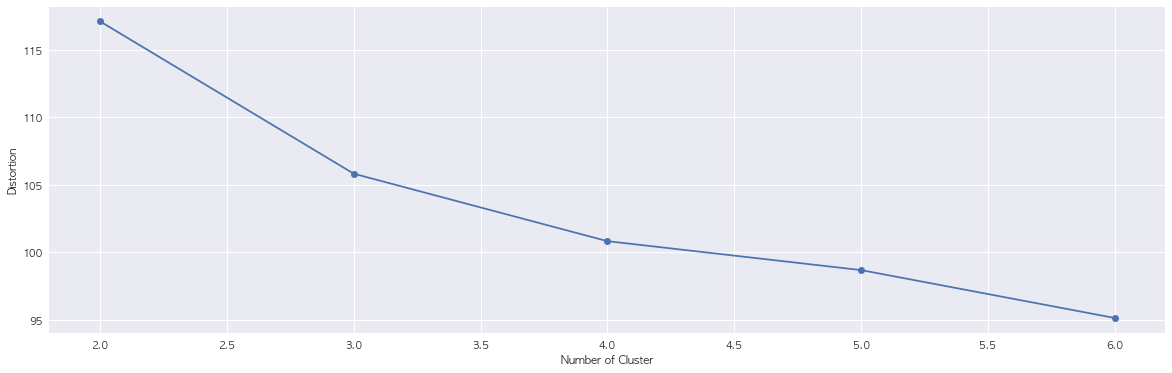

CPU times: user 12min 54s, sys: 1min 1s, total: 13min 55s
Wall time: 5min 47s


In [117]:
%time  visualize_elbowmethod(beauty_ts)

## 3. TimeSeries K Means

In [118]:
model2 = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=300, random_state=1234, n_jobs=-1)

for i in tqdm(range(len(beauty_ts))) : 
    model2.fit(beauty_ts)

100%|██████████| 131/131 [1:32:09<00:00, 42.21s/it]


In [119]:
df_beauty_result = pd.DataFrame({
    'sm_cat' : beauty_ts.index, 
    'cluster' : model2.labels_
})

In [120]:
df_beauty_result.cluster.value_counts()

0    47
1    36
2    30
3    18
Name: cluster, dtype: int64

In [121]:
# 몽땅 클러스터 
df_beauty_result[df_beauty_result.cluster==0]

,sm_cat,cluster
2,기능성 아이케어 화장품,0
3,기능성 영양보습 화장품,0
4,기능성 트러블케어 화장품,0
7,기초 화장용 로션,0
9,기초 화장용 스킨,0
10,기초 화장용 에센스,0
11,기초 화장용 오일/앰플,0
12,기초 화장용 크림,0
13,남성 로션,0
14,남성 메이크업,0


In [122]:
# 여름 인기 제품! 
df_beauty_result[df_beauty_result.cluster==1]

,sm_cat,cluster
15,남성 선케어,1
21,남성 클렌징,1
23,네일 메이크업 용품,1
24,네일관리 소품,1
26,네일세트,1
29,네일케어,1
30,데오드란트,1
39,바디 클렌져,1
40,바디케어용 땀패드,1
44,바디케어용 제모제,1


In [123]:
df_beauty_result[df_beauty_result.cluster==2]

,sm_cat,cluster
5,기능성 화이트닝 화장품,2
6,기능성 화장품 세트,2
8,기초 화장용 미스트,2
20,남성 크림,2
22,남성향수,2
25,네일리무버,2
37,바디 세트,2
38,바디 스크럽,2
41,바디케어용 때비누,2
45,바디케어용 청 결제,2


In [124]:
df_beauty_result[df_beauty_result.cluster==3]

,sm_cat,cluster
0,기능성 링클케어 화장품,3
1,기능성 모공관리 화장품,3
27,네일아트,3
28,네일컬러,3
33,메이크업 박스,3
42,바디케어용 볼륨업크림,3
43,바디케어용 슬리밍,3
46,베이스 메이크업 세트,3
48,베이스 메이크업용 CC크림,3
51,베이스 메이크업용 컨실러,3


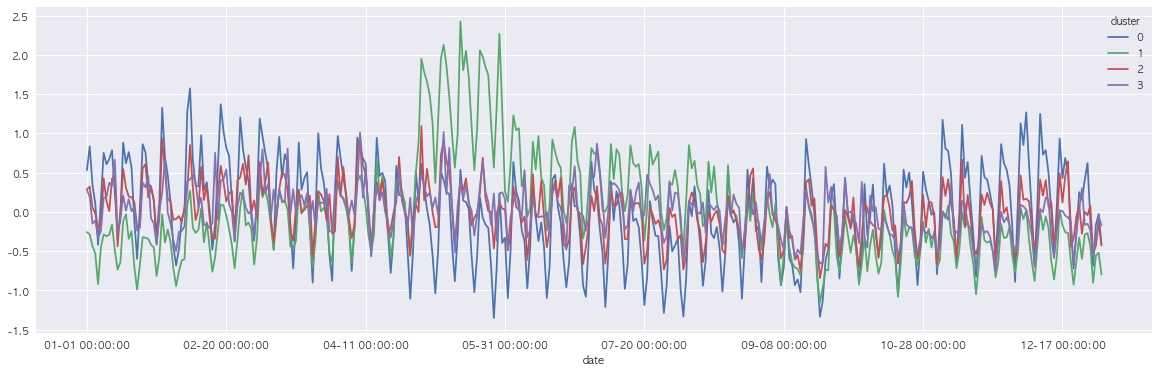

In [125]:
beauty_ts["cluster"] = model2.labels_

plt.rcParams["figure.figsize"]=(20,6)
beauty_ts.groupby(['cluster']).mean().T.plot()
plt.show()

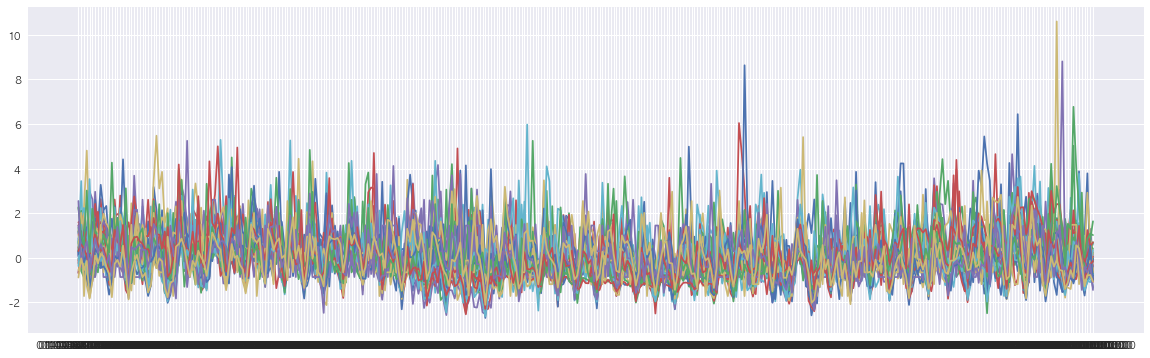

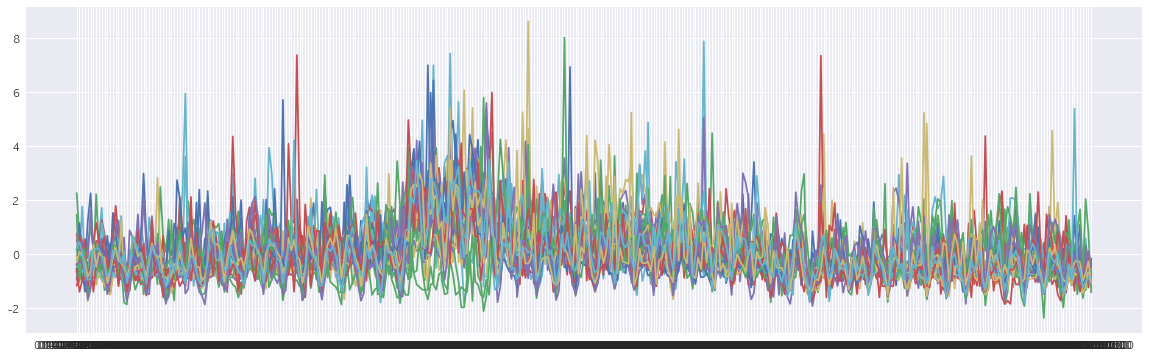

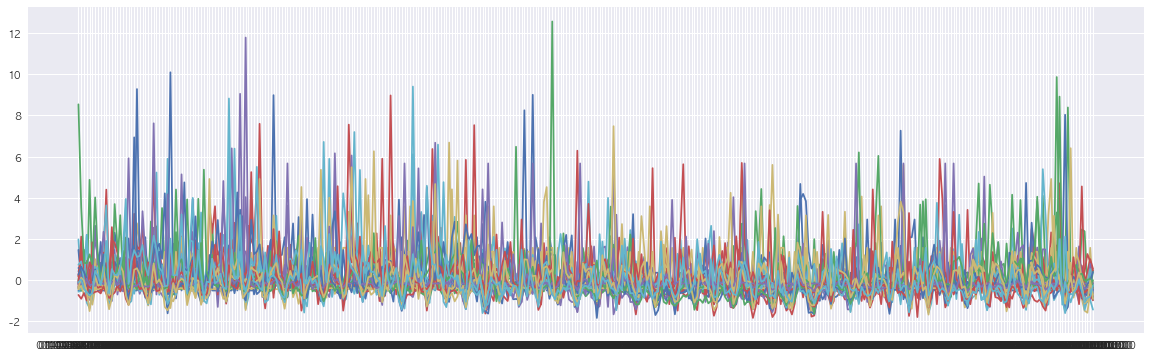

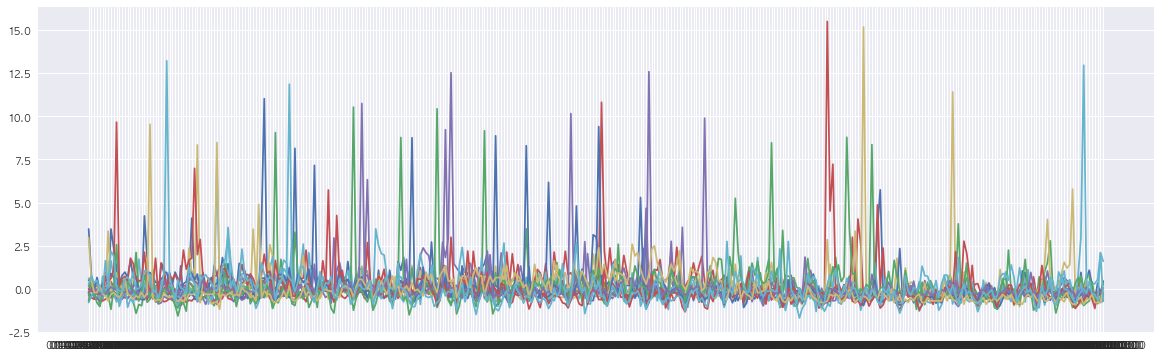

In [126]:
for i in range(4):
    clusters = beauty_ts[beauty_ts['cluster']==i]
    clusters.drop(['cluster'], axis=1, inplace=True)
    plt.figure(figsize=(20,6))
    plt.plot(clusters.T)
    plt.show

In [127]:
beauty_ts["cluster"] = model2.labels_
beauty_ts.to_csv("beauty_tsclustering.csv", index=False, encoding='cp949')